<div style="display: flex; align-items: center; justify-content: flex-start; text-align: left; width: fit-content; margin: 0 auto;">
    <img src="https://media.giphy.com/media/LO8oXHPum0xworIyk4/giphy.gif?cid=ecf05e47mbgvh6ylsgvcjv4motlmhj5eqzukcs5tg9kltdn3&ep=v1_gifs_search&rid=giphy.gif&ct=g"
         style="max-width: 30px; margin-right: 10px;">
    <span>Starting from 7th notebook versions I use recalculated SII scores (see explanations below).</span>
</div>

In [230]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

# Understanding the task

The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features. 

sii is derived from `PCIAT-PCIAT_Total`, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

Target Variable (sii) is defined as:
- 0: None (PCIAT-PCIAT_Total from 0 to 30)
- 1: Mild (PCIAT-PCIAT_Total from 31 to 49)
- 2: Moderate (PCIAT-PCIAT_Total from 50 to 79)
- 3: Severe (PCIAT-PCIAT_Total 80 and more)

This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Type of Machine Learning Problem we can use with sii as a target:

1. Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)
2. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
3. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)
4. Custom (e.g. loss functions that penalize errors based on the distance between categories)

We can also use `PCIAT-PCIAT_Total` as a continuous target variable, and implement regression on `PCIAT-PCIAT_Total` and then map predictions to sii categories.

Finally, another strategy involves predicting responses to each question of the Parent-Child Internet Addiction Test: i.e. pedict individual question scores as separate targets, sum the predicted scores to get the `PCIAT-PCIAT_Total` and map predictions to the corresponding sii category.


But first, let's make some exploratory data analysis.

# Data Preview

In [231]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

Let's identify the features that are related to the target variable and that are not present in the test set.

In [232]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


In [233]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

**Parent-Child Internet Addiction Test (PCIAT):** contains 20 items (`PCIAT-PCIAT_01` to `PCIAT-PCIAT_20`), each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction.

We also have season of participation in `PCIAT-Season` and total Score in `PCIAT-PCIAT_Total`; so there are 22 PCIAT test-related columns in total.

Let's verify that the `PCIAT-PCIAT_Total` align with the corresponding sii categories by calculating its minimum and maximum scores for each sii category:

In [234]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [235]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

### Check missing answers

<div style="display: flex; justify-content: flex-start; align-items: flex-start; text-align: left;">
    <img src="https://media.giphy.com/media/LO8oXHPum0xworIyk4/giphy.gif?cid=ecf05e47mbgvh6ylsgvcjv4motlmhj5eqzukcs5tg9kltdn3&ep=v1_gifs_search&rid=giphy.gif&ct=g" style="max-width: 3%; margin-right: 10px;">
    <span style="display: inline-block;">Thanks to a nice catch by Broccoli Beef (<a href="https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/536407#3000620">here</a>) we also know that some of the Parent-Child Internet Addiction Test questions can be ignored by a respondent (missing values in the PCIAT-PCIAT_01 to PCIAT-PCIAT_20 columns), but the SII score is still derived from the the sum of the non-NA values, leading to potentially invalid SII values (unless, of course, some answers were cut out after the data has been collected, just to give us a bit more of a challenge.)</span>
</div>

In [236]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

/tmp/ipykernel_36/3411083672.py:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(


,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


For example, in the 1st and 3rd rows you can see that the score for one answer is missing. And since each question is scored from 1 to 5, the total score could be up to 5 points higher and correspond to the next SII category (SII can be 0 or 1 for the first row and 1 or 2 for the third). For the second row, `PCIAT-PCIAT_Total` and `sii` appears to have been filled in by mistake, as there are no test questions answered at all.

Let's check if PCIAT-PCIAT_Total was indeed calculated as a sum of non-NA values in  `PCIAT-PCIAT_01` to `PCIAT-PCIAT_20` columns:

In [237]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

For now, we can conclude that the SII score is sometimes incorrect. Below I recalculate the SII based on `PCIAT_Total` and the maximum possible score if missing values were answered (5 points), ensuring that the recalculated SII meets the intended thresholds even with some missing answers.

In [241]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

KeyError: 'PCIAT-PCIAT_Total'

Verification of rows with different original and recalculated SII:

In [239]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

/tmp/ipykernel_36/2850448006.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  ]].style.applymap(


,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Well, for 17 rows the target variable was calculated incorrectly (ignoring missing responses).
</div>

In [240]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)
test.drop(columns='recalc_sii', inplace=True)

KeyError: "['recalc_sii'] not found in axis"

### Plot distribution of the target variable

### SII by age and sex

In [ ]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

In [ ]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

In [ ]:
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Internet Use

Internet usage data is crucial to this task because Problematic internet use (PIU), also known as internet addiction or compulsive internet use, refers to excessive and unhealthy use of the internet that interferes with a person’s daily life, responsibilities, and social relationships. The internet usage data provides a direct measure of how much time each participant spends online.

In [ ]:
data = train[train['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data:"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
train['PreInt_EduHx-computerinternet_hoursday'].unique()

In [ ]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [ ]:
calculate_stats(train, 'PreInt_EduHx-Season')

In [ ]:
train_non_na = train.dropna(subset=['PreInt_EduHx-computerinternet_hoursday'])
rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 3).sum()
print(f"Non-NA Rows - Internet use 3h or more: {(rows / len(train_non_na)) * 100:.2f}%")

rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 0).sum()
print(f"Non-NA Rows - Internet use 1h or less: {(rows / len(train_non_na)) * 100:.2f}%")

In [ ]:
stats = train.groupby(['Basic_Demos-Sex', 'internet_use_encoded']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

### Internet usage vs SII (target)

Competition description states that the goal is: to detect early indicators of problematic Internet and technology use (PIU), while the definition of PUI includes excessive use of internet:

> PUI is an umbrella term that encompasses a set of potentially harmful online behaviors that are repetitive and uncontrolled, to the point that they are prioritized over other life interests and persist despite negative consequences.

*[Fendel, J. C., Vogt, A., Brandtner, A., & Schmidt, S. (2024). Mindfulness programs for problematic usage of the internet: A systematic review and meta-analysis. Journal of behavioral addictions, 13(2), 327–353.](https://doi.org/10.1556/2006.2024.00024)*

So let's see how much time the participants with different impairment scores (SII) spent online in this dataset.

In [ ]:
sii_reported = train[train['sii'] != "Missing"]
sii_reported.loc[:, 'sii'] = sii_reported['sii'].cat.remove_unused_categories()

In [ ]:
stats = sii_reported.groupby(
    ['internet_use_encoded', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

In [ ]:
train[
    (train['internet_use_encoded'] == '< 1h/day') & 
    (train['sii'].isin(['2 (Moderate)', '3 (Severe)']))
]['Basic_Demos-Age'].describe()

# Features EDA by Groups

Here’s how we can classify types of the features in this dataset:

- Categorical: Variables with discrete categories but no inherent order (represented as strings, e.g., season of enrollment)
- Encoded categorical features (already encoded as integers, e.g. sex)
- Continuous: Variables that can take any value within a range (e.g., age, enmo, heart_rate).
- Ordinal: Variables with a defined order but not necessarily equidistant categories (e.g., questionnaire responses).

And here are different features groups:

In [ ]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

### Season-related columns

The presence of different season-related columns likely reflects the timing of data collection or participation in the study. Seasonal changes may play a significant role in the variables being measured (e.g., fitness, physical activity, sleep patterns, and of course internet usage).

In [ ]:
season_columns = [col for col in train.columns if 'Season' in col]
season_df = train[season_columns]
season_df

In [ ]:
train[season_columns] = train[season_columns].fillna("Missing")

### Grouping of features by type and measurement method
Having examined the contents of data_dict in detail, I believe that the characteristics can also be grouped according to their type and method of measurement (the diagram was made with [napkin](https://app.napkin.ai/)):


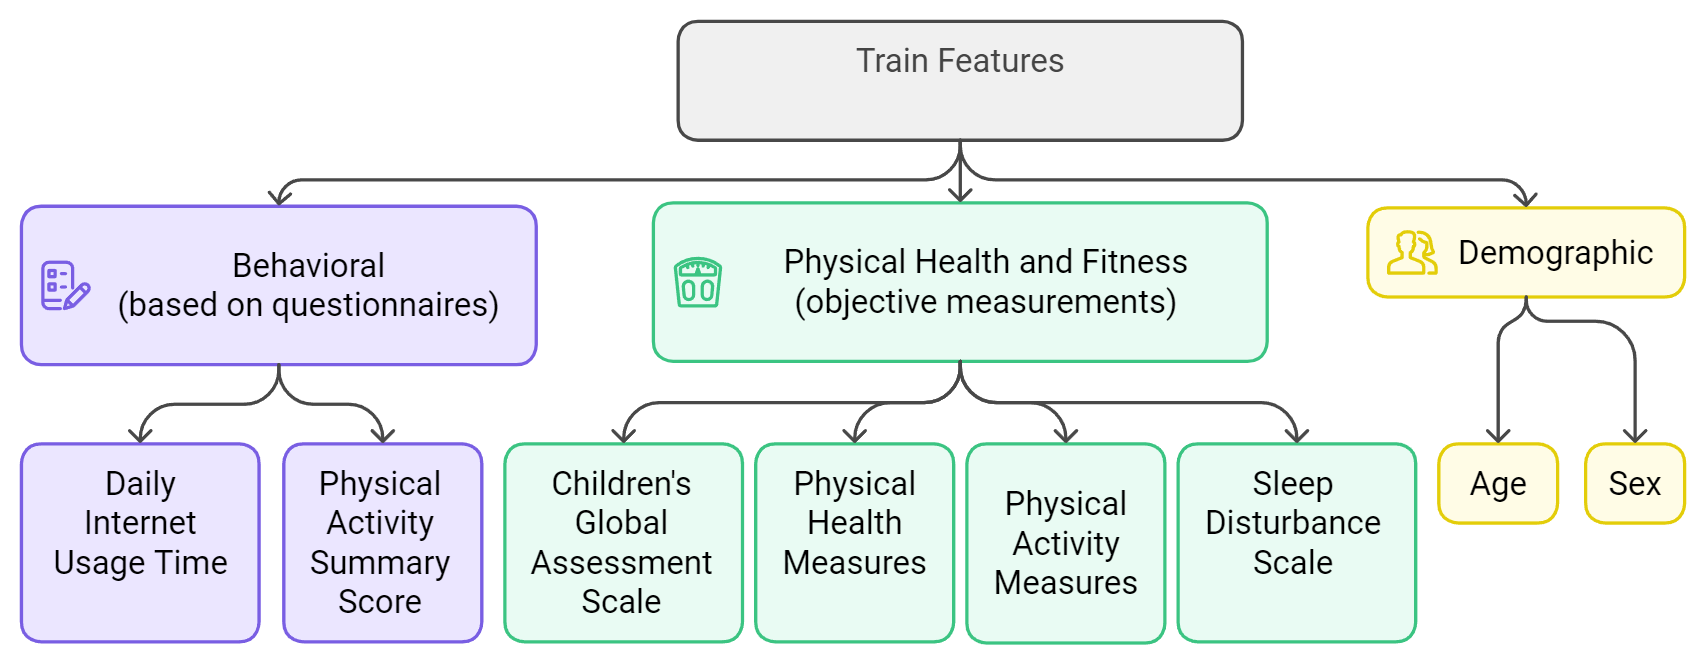

### Potential connection to problematic internet use (PIU)
- Behavioral (subjective reported):
  - A person can't have PIU if they don't use the internet, so I would expect `PreInt_EduHx-computerinternet_hoursday` to be the most important feature, but as we saw above, its relationship with the target can be non-linear.
  - Behavioural tendencies associated with PIU may be reflected in the physical activity score derived from the questionnaires (`PAQ_A-PAQ_A_Total` and `PAQ_C-PAQ_C_Total`).   
  
  However, both features are self-reports and are likely to be biased and inaccurate, so I would expect noise here.
  
- Physical Health and Fitness (objective measurements):
  - The Children's Global Assessment Scale (`CGAS-CGAS_Score`) is a clinician-rated score reflecting general functioning. For individuals with PIU, this score can indicate how PIU impacts overall functioning.
  - Physical health measures include body composition and vital signs (feature columns starting with `Physical-`), and may reflect how problematic internet use is in terms of its impact on general health (note that height alone may not be as relevant, but combined with weight it gives BMI - a measure of body fat).
  - Bio-electric Impedance Analysis assess body composition and metabolic health (body fat, muscle mass, water content, metabolic rate, etc.), PIU, if assosiated with sedentary behavior could be reflected through changes in these variables (lower bone density, lower lean muscle mass, reduced daily energy expenditure, poor hydration, decrease in fat-free mass, higher body fat percentages, and so on).
  - Objective measures of physical activity include FitnessGram results (endurance, curl, grip, push-up, sit & reach, trunk lift - feature columns starting with `Fitness_` and `FGC-FGC_`). These can indicate how problematic internet use is in terms of its impact on muscle strength and tonus.
  - An assessment of sleep-related issues (feature columns `SDS-SDS_Total_Raw`, `SDS-SDS_Total_T`) could reflect the extent to which PIU disrupts sleep patterns.
- Demographic features:
  - Age and gender can be extremely important, as there may be gender and especially age-specific patterns (as we have already seen above) associated with Internet use and PIU)

Remove target-related columns and continue EDA by feature groups.

In [ ]:
data_dict = data_dict[data_dict['Instrument'] != 'Parent-Child Internet Addiction Test']
continuous_cols = data_dict[data_dict['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()


In [ ]:
groups.get("Children's Global Assessment Scale", [])

In [ ]:
data = train[train['CGAS-CGAS_Score'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with CGAS-CGAS_Score data:"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
calculate_stats(train, 'CGAS-CGAS_Score')

In [ ]:
train[train['CGAS-CGAS_Score'] > 100]

In [ ]:
train.loc[train['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan

Stats without outlier:

### CGAS Interpretation ([Reference](https://www.corc.uk.net/outcome-experience-measures/childrens-global-assessment-scale-cgas/))

CGAS is a rating of general functioning for children and young people aged 4-16 years old. The CGAS asks the clinician to rate the child from 1 to 100 based on their lowest level of functioning, regardless of treatment or prognosis, over a specified time period.

Since the CGAS is a measure of general functioning, and the SII reflects the severity of the impact of Internet use on that functioning, I expect this feature, along with Internet use, to be the most important in predicting the SII.

Let's bin the `CGAS-CGAS_Score` column based on the established score categories and draw counts:

In [ ]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')

for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The majority of individuals have CGAS scores between 51-80 (79.7%), i.e. sporadic difficulties to only slight impairments
<li>Two participants have extreme difficulty in functioning
    </ul>
</div>

Examine relationships with the target variable:

In [ ]:
train_filt = train.dropna(subset=['CGAS_Score_Bin', 'complete_resp_total'])
train_filt.loc[:, 'CGAS_Score_Bin'] = train_filt['CGAS_Score_Bin'].cat.remove_unused_categories()
train_filt.loc[:, 'sii'] = train_filt['sii'].cat.remove_unused_categories()
len(train_filt)

In [ ]:
score_min_max = train.groupby('sii')['CGAS-CGAS_Score'].agg(['min', 'max'])
score_min_max = score_min_max.rename(
    columns={'min': 'Minimum CGAS Score', 'max': 'Maximum CGAS Score'}
)
score_min_max

Let's check the SII and Internet usage data for the participants with the worst global functioning:

In [ ]:
train_filt[train_filt['CGAS-CGAS_Score'] < 35][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

And the same for the participants with the best global functioning:

In [ ]:
train[train['CGAS-CGAS_Score'] > 90][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>I would expect the higher the SII, the lower the median CGAS score, but the decrease is very small here.
<li>However, there are no participants with the highest SII scores (3 or severely problematic internet use) who have good CGAS scores (81-100: good/superior functioning in all domains). This suggests that parental responses to the PCIAT questionnaire (our target variable) may reflect some effects of PIU on global health and functioning.
<li>The participants with the worst and best CGAS scores all have SII 0 or 1 (no or mild PIU severity) and report varying internet use (less than 1 hours/day to 3 or more hours/day). This means in the train data there are participants with significant health issues not related to PIU.
<li>The high variability makes it hard to draw a clear, consistent conclusion about the relationship between CGAS and SII scores. 
<li>Small sample sizes in certain CGAS categories make it difficult to generalize findings and may lead to biased interpretations.
    </ul>
</div>

# - Physical Measures

In [ ]:
groups.get('Physical Measures', [])

In [ ]:
features_physical = groups.get('Physical Measures', [])
cols = [col for col in features_physical if col in continuous_cols]

plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(cols) // n_cols + 1

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train[col].hist(bins=20)
    plt.title(col)

plt.subplot(n_rows, n_cols, len(cols) + 1)
season_counts = train['Physical-Season'].value_counts(dropna=False)
plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('Physical-Season')

plt.suptitle('Histograms for Physical Measures and Physical-Season Pie Chart', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
calculate_stats(train, cols)

### Weight and Height

In [ ]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

The minimum values of 0 for measures like BMI, weight, and blood pressure are biologically unrealistic, and likely indicate missing or erroneous data. Let's  check number of zeros in these columns:

In [ ]:
train[wh_cols] = train[wh_cols].replace(0, np.nan)

Convert weight to kilograms, and height to centimeters and recalculate BMI:

In [ ]:
lbs_to_kg = 0.453592
inches_to_cm = 2.54

train['Physical-Weight'] = train['Physical-Weight'] * lbs_to_kg
train['Physical-Height'] = train['Physical-Height'] * inches_to_cm
train['Physical-Waist_Circumference'] = train['Physical-Waist_Circumference'] * inches_to_cm

# Recalculate BMI: BMI = weight (kg) / (height (m)^2)
train['Physical-BMI'] = np.where(
    train['Physical-Weight'].notna() & train['Physical-Height'].notna(),
    train['Physical-Weight'] / ((train['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

calculate_stats(train, wh_cols)

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Weight and height both increase with age, and waist circumference and weight are highly correlated, as expected.
<li>However, there are individuals who are unusually tall for their age group or who are extremely overweight.
<li>There are also a few outliers in the waist circumference measurements, which are possible artifacts (e.g. 100 cm for a weight of 40 kg).
<li>The problem with data cleaning here is that we cannot guess which of the data is correct. For example, we may see an unrealistic combination of a waist circumference of 100cm and a weight of 40kg for a participant, but where is the error in the waist circumference or the weight? Or a height of around 175cm for a child of 7... has the height or age been entered incorrectly? Or this is true data and the child has gigantism or another disorder related to the growth hormone?
    </ul>
</div>

### Blood Pressure & Heart Rate

There is 1000% incorrect data in the BP/HR columns as the minimum values are lethal to humans. We can clean up these kinds of mistakes.

In [ ]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

In [ ]:
(train[bp_hr_cols] < 50).sum()

We also know that systolic BP cannot be lower than diastolic BP:

In [ ]:
train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][bp_hr_cols]

These are certainly incorrect measurements. But again, we can't be sure which information is correct, so we can either flag these rows for further manual inspection one by one, or replace all suspicious values with NaN. For this analysis I only remove 0 values and both BP if systolic is lower or equal to diastolic.

In [ ]:
train[cols] = train[cols].replace(0, np.nan)
train.loc[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP'], bp_hr_cols] = np.nan

### Compare to normal rages 

Now we'll define approximate normal ranges for each column and count the number of rows that fall outside these ranges. As normal values can vary widely between the ages of 5 and 22, **I use values that are general estimates; for more precise results you can refer to BMI-for-age growth charts on the CDC or WHO websites, for example.**

In [ ]:
normal_ranges = {
    'Physical-BMI': (18.5, 24.9),
    'Physical-Height': (100, 193),
    'Physical-Weight': (20, 120),
    'Physical-Waist_Circumference': (50, 90),
    'Physical-Diastolic_BP': (60, 80),
    'Physical-HeartRate': (60, 100),
    'Physical-Systolic_BP': (90, 120)
}

def count_out_of_range(data, column, low, high):
    return ((data[column] < low) | (data[column] > high)).sum()

In [ ]:
out_of_range_counts = {
    col: count_out_of_range(train, col, *normal_ranges[col])
    for col in normal_ranges
}
print("Number of rows with values outside normal ranges:")

for col, count in out_of_range_counts.items():
    total_valid = train[col].notna().sum()
    percentage = (count / total_valid) * 100
    print(f"{col}: {count} ({percentage:.2f}%)")

Group BMI by obesity level according to [WHO BMI-for-age (5-19 years)](https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age)

In [ ]:
bmi_categories = [
    ('Underweight', train['Physical-BMI'] < 18.5),
    ('Normal weight', (train['Physical-BMI'] >= 18.5) & (train['Physical-BMI'] <= 24.9)),
    ('Overweight', (train['Physical-BMI'] >= 25) & (train['Physical-BMI'] <= 29.9)),
    ('Obesity', train['Physical-BMI'] >= 30)
]
bmi_category_counts = {label: condition.sum() for label, condition in bmi_categories}

plt.figure(figsize=(5, 6))
plt.pie(bmi_category_counts.values(),
        labels=bmi_category_counts.keys(),
        autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3.colors)
plt.title('BMI Distribution by Category')
plt.axis('equal')
plt.show()

### Check extreme deviations cases

In [ ]:
train[train['Physical-BMI'] < 12][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-BMI')

In [ ]:
train[train['Physical-Systolic_BP'] > 160][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-Systolic_BP')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>A significant number of participants, especially for BMI and blood pressure, fall outside the expected normal ranges
        <li>Most participants' heights and weights are within reasonable ranges, but many have BMIs outside the approximate normal range, suggesting that many participants may have disproportionate body proportions (or incorrect measurements?). For a more accurate understanding, age-specific reference values need to be used.
    </ul>
</div>

### Relationships with the target variable (PCIAT_Total for complete PCIAT responses)

In [ ]:
data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()



# - Bio-electric Impedance Analysis

In [ ]:
data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']

There is no information in the competition description about what equipment was used, is this raw data or did they use some BIA equation models to estimate the parameters. But it's likely that the BIA data has already been processed using a BIA equation model. It is very important to note that BIA is not a precise method, for example it tends to overestimate muscle mass, so equations have been developed to estimate muscle mass based on factors such as age, sex, height, weight and resistance and/or reactance estimated by BIA... a large number of prediction equation models have been generated through various validation studies ([link](https://clinicalnutritionespen.com/article/S2405-4577(19)30478-4/fulltext)). It is essential that all recordings are processed with the same equation, but we cannot be sure. 

In [ ]:
bia_data_dict = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']
categorical_columns = bia_data_dict[bia_data_dict['Type'] == 'categorical int']['Field'].tolist()
continuous_columns = bia_data_dict[bia_data_dict['Type'] == 'float']['Field'].tolist()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Season
season_counts = train['BIA-Season'].value_counts(normalize=True)
axes[0].pie(
    season_counts, 
    labels=season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
axes[0].set_title(
    f"{bia_data_dict[bia_data_dict['Field'] == 'BIA-Season']['Description'].values[0]}"
)
axes[0].axis('equal')

# Other categorical columns
for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, palette="Set3", ax=axes[idx+1])
    axes[idx+1].set_title(data_dict[data_dict['Field'] == col]['Description'].values[0])

plt.tight_layout()
plt.show()

### Compare the two measured BMI

In [ ]:
bmi_data = train[['BIA-BIA_BMI', 'Physical-BMI']].dropna()


In [ ]:
bmi_measures = train[['BIA-Season', 'Physical-Season']].dropna()
bmi_measures.groupby(['BIA-Season', 'Physical-Season']).size().reset_index(name='Count')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: This may not be exactly correct, because above I found zeros in the physical measurements and recalculated the BMI... As we can see, this BMI measured during the bioelectrical impedance also contains zeros that I cannot explain and that seem to be errors.
</div>

I am afraid that it will be meaningless to examine the relationships with the target variable, as there is too much unknown about these data (how they were collected and processed, what the reference values are, etc.).

# - FitnessGram

## FitnessGram Vitals and Treadmill

In [ ]:
groups.get('FitnessGram Vitals and Treadmill', [])

In [ ]:
data = train[train['Fitness_Endurance-Max_Stage'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with Fitness_Endurance-Max_Stage data:"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Fitness Endurance Season
train['Fitness_Endurance-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors, ax=axes[0]
)
axes[0].set_title('Fitness Endurance Season')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Box plot for Max Stage by Season
sns.violinplot(
    x='Fitness_Endurance-Season',
    y='Fitness_Endurance-Max_Stage',
    data=train, palette="Set3",
    ax=axes[1]
)
axes[1].set_title('Max Stage by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Max Stage')

# Fitness Endurance Time (Minutes)
sns.histplot(train['Fitness_Endurance-Time_Mins'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Fitness Endurance Time (Minutes)')
axes[2].set_xlabel('Time (Minutes)')

# Fitness Endurance Time (Seconds)
sns.histplot(train['Fitness_Endurance-Time_Sec'], bins=20, kde=True, ax=axes[3])
axes[3].set_title('Fitness Endurance Time (Seconds)')
axes[3].set_xlabel('Time (Seconds)')

plt.tight_layout()
plt.show()

Endurance by age:

In [ ]:
plt.figure(figsize=(12, 5))

sns.violinplot(x='Basic_Demos-Age', y='Fitness_Endurance-Max_Stage', data=train, palette="Set3")
plt.title('Fitness Endurance Max Stage by Age')
plt.xlabel('Age')
plt.ylabel('Max Stage')

plt.tight_layout()
plt.show()

In [ ]:
cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]
calculate_stats(train, cols)

- Fitness_Endurance-Max_Stage: likely represents the maximum stage reached during an endurance test. In fitness endurance tests like a treadmill test or a multi-stage fitness test (beep test), participants progress through increasing levels of difficulty (speed or incline), and this column records the highest level or stage completed by the participant before stopping.
- Fitness_Endurance-Time_Mins: could be the duration a participant was able to sustain the test before reaching exhaustion, measured in minutes
- Fitness_Endurance-Time_Sec: I guess combining both columns (minutes and seconds) would give the exact total time of the endurance test completed by the participants.

### Check the combinations of missing values

Max_Stage present, time (mins or secs) missing:

In [ ]:
train[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna())
][cols]

It's possible that during data entry minutes or seconds were left blank (entered as NaN) when they should have been recorded as 0 minutes/seconds. While the missing seconds are not as important, the missing minutes may actually be missing and treating them as 0 would give an incorrect test result. I think it's better to just remove these suspicious cases.

In [ ]:
train.loc[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna()), cols
] = np.nan

Get one time column (mins + sec)

In [ ]:
train['Fitness_Endurance-Total_Time_Sec'] = train[
    'Fitness_Endurance-Time_Mins'
] * 60 + train['Fitness_Endurance-Time_Sec']

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>On average, participants reached stage 5 in the endurance test.
<li>Some participants failed to complete the first stage (min = 0), or these are errors in data again.
<li>There is a small number of participants with exceptionally high endurance of age 7-8 years.
<li>There is a substantial amount of missing data (over 80% of the dataset lacks this information).
    </ul>
</div>

## FitnessGram Child

In [ ]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

In [ ]:
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']
        
        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]
        
        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))
            
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4
    
    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal') 

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Most of the distributions are skewed towards lower performance totals.
<li>Strangely, a greater proportion of participants achieved a healthy fitness zone for the trunk lift.
<li>I would expect different ranges for each zone, but the values for different zones overlap significantly. This may be because the zone ranges are different for different ages.
    </ul>
</div>

In [ ]:
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

### Overlap between fitness zones

In [ ]:
def compute_min_max_by_sex(train, sex, fgc_columns):
    results = []
    
    for measure, zone, _, _ in fgc_columns:
        sorted_zones = sorted(train[zone].dropna().unique())
        
        for zone_value in sorted_zones:
            data = train[(train[zone] == zone_value) & 
                         (train['Basic_Demos-Sex'] == sex)][measure]
            
            if not data.empty:
                min_val, max_val = data.min(), data.max()
                results.append({
                    'Zone': int(zone_value),
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })
    
    df = pd.DataFrame(results).pivot_table(
        index='Zone', columns='Measure', values='Min-Max', aggfunc='first'
    )
    
    return df

Output ranges for each measure and zone for males:

In [ ]:
compute_min_max_by_sex(train, 'Male', fgc_columns)

Same for females;

In [ ]:
compute_min_max_by_sex(train, 'Female', fgc_columns)

The ranges for each measure and zone by age (only for males, just to check if the overlap still exists):

In [ ]:
results_male = []

for measure, zone, _, _ in fgc_columns:
    sorted_zones = sorted(train[zone].dropna().unique())
    for zone_value in sorted_zones:
        age_sex_data_by_zone = train[train[zone] == zone_value][
            ['Basic_Demos-Age', 'Basic_Demos-Sex', measure]
        ]
        unique_ages = age_sex_data_by_zone['Basic_Demos-Age'].dropna().unique()

        for age in sorted(unique_ages):
            age_sex_data = age_sex_data_by_zone[
                (age_sex_data_by_zone['Basic_Demos-Age'] == age) &
                (age_sex_data_by_zone['Basic_Demos-Sex'] == 'Male')
            ][measure]
            
            if not age_sex_data.empty:
                min_val, max_val = age_sex_data.min(), age_sex_data.max()
                results_male.append({
                    'Age': age,
                    'Sex': 'Male',
                    'Zone': zone_value,
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })

df_male = pd.DataFrame(results_male).pivot_table(
    index=['Age', 'Sex', 'Zone'], columns='Measure', values='Min-Max', aggfunc='first'
)

df_male

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The table shows the min-max ranges for various fitness measures (such as curl-ups, grip strength, push-ups, sit-and-reach, and trunk lifts) across different ages and zones.
<li>There is a significant overlap in min-max ranges across different zones within the same age group for some measures. For example, at age 9: 6 to 10 curl-ups may correspond to Zone 0 (Needs Improvement) or Zone 1 (Healthy Fitness Zone).
<li>This overlap indicates that the criteria for each zone are not sharply defined by specific ranges, even for the same age, and these zone columns appear to be features that just add extra noise, I would not use them in modelling.
    </ul>
</div>


### Age Ranges for each measurement column

In [ ]:
age_ranges = []

for measure in measurement_columns:
    valid_rows = train[~train[measure].isna()]
    
    min_age = valid_rows['Basic_Demos-Age'].min()
    max_age = valid_rows['Basic_Demos-Age'].max()
    
    age_ranges.append({
        'Measurement': measure,
        'Min Age': min_age,
        'Max Age': max_age
    })

age_ranges_df = pd.DataFrame(age_ranges)
age_ranges_df

In addition, it also doesn't make sense to call this a children's FitnessGram, since participants of almost all ages (5-21) were tested.

## Relationships with the target variable (PCIAT_Total for complete PCIAT responses)

In [ ]:
cols = [col for col in train.columns if col.startswith('FGC-') 
        and 'Zone' not in col and 'Season' not in col]
cols.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There are noticeable intercorrelations between the fitness measures (FGC-FGC_GSD (grip strength dominant) and FGC-FGC_GSND (grip strength non-dominant), FGC-FGC_SRL (sit & reach left) and FGC-FGC_SRR (sit & reach right)) and they are expected to be similar.
<li>The relationships with the target variable appear to be a counterintuitive: curl-ups and push-ups show moderate positive relationships with PIU severity, and trunk lift and grip strength show a weak positive correlation, suggesting that physical performance improves as PIU severity increases...
<li>Better performance in fitness tests does not necessarily indicate a higher level of daily physical activity. Besides, fitness measures might reflect past - we do not know the timing of the measurements.
<li>But the main thing to remember here is that physical performance also improves with age, so the positive correlation between physical performance and PIU severity is likely just driven by age.
<li>And here is another unknown: were the fitness tests conducted in a standardized way across all participants?
    </ul>
</div>

Let's see how the picture changes when we plot the same thing by age group, and add age to see if the measures still correlate with age.

In [ ]:
age_groups = train['Age Group'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, age_group in enumerate(age_groups):
    group_data = train[train['Age Group'] == age_group]
    corr_matrix = group_data[cols + ['complete_resp_total', 'Basic_Demos-Age']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f',
                vmin=-1, vmax=1, ax=axes[i], cbar=i == 0)
    axes[i].set_title(f'{age_group}')

plt.tight_layout()
plt.show()

In [ ]:
train[
    (train['Age Group'] == 'Adults (19-22)') &
    (train['complete_resp_total'].notna()) &
    (train[cols].notna().any(axis=1))
][cols + ['complete_resp_total', 'Basic_Demos-Age']]

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>In each age group we see that age correlates well with most measures of physical performance (especially for kids and adults).
<li>The correlation between age and PIU severity persists in children aged 5-12 years, confounding the relationship between fitness and PIU.
<li>For adolescents, the correlations of the target variable with all measures of fitness are weak or null, and for adults who pass the fitness test, only 1 has data on PIU severity.
<li>In overall, fitness measures do not show noticable correlations with PIU severity, and it appears that age may be driving both increased fitness performance and higher PIU severity
    </ul>
</div>

# - Sleep Disturbance Scale

In [ ]:
groups.get('Sleep Disturbance Scale', [])

In [ ]:
data = train[train['SDS-SDS_Total_Raw'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with SDS-SDS_Total_Raw data:"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
plt.figure(figsize=(18, 5))

# SDS-Season (Pie Chart)
plt.subplot(1, 3, 1)
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)
plt.pie(
    sds_season_counts, 
    labels=sds_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('SDS-Season')

# SDS-SDS_Total_Raw
plt.subplot(1, 3, 2)
sns.histplot(train['SDS-SDS_Total_Raw'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_Raw')
plt.xlabel('Value')

# SDS-SDS_Total_T
plt.subplot(1, 3, 3)
sns.histplot(train['SDS-SDS_Total_T'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_T')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
calculate_stats(train, ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'])

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Both the raw and T-scores for sleep disturbance are moderately variable, with some extreme values indicating severe sleep disturbances in a subset of participants.
<li>Further Analysis (coming soon): to explore whether specific demographic factors (e.g., age, gender, season) are associated with higher sleep disturbance scores.
    </ul>
</div>

# - Physical Activity Questionnaire

### Adolescents

In [ ]:
groups.get('Physical Activity Questionnaire (Adolescents)', [])

In [ ]:
data = train[train['PAQ_A-PAQ_A_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Adolescents (with PAQ_A_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
plt.figure(figsize=(18, 5))

# PAQ_A-Season
plt.subplot(1, 3, 1)
train['PAQ_A-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_A-Season (Adolescents)')

# PAQ_A-PAQ_A_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_A-PAQ_A_Total'], bins=20, kde=True)
plt.title('PAQ_A-PAQ_A_Total (Adolescents)')

# PAQ_A_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', data=train, palette="Set3")
plt.title('PAQ_A_Total by Season (Adolescents)')

plt.tight_layout()
plt.show()

In [ ]:
calculate_stats(train, ['PAQ_A-PAQ_A_Total'])

### Children

In [ ]:
groups.get('Physical Activity Questionnaire (Children)', [])

In [ ]:
data = train[train['PAQ_C-PAQ_C_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Children (with PAQ_C_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

In [ ]:
plt.figure(figsize=(18, 5))

# PAQ_C-Season
plt.subplot(1, 3, 1)
train['PAQ_C-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_C-Season (Children)')

# PAQ_C-PAQ_C_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_C-PAQ_C_Total'], bins=20, kde=True)
plt.title('PAQ_C-PAQ_C_Total (Children)')

# PAQ_C_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', data=train, palette="Set3")
plt.title('PAQ_C_Total by Season (Children)')

plt.tight_layout()
plt.show()

In [ ]:
calculate_stats(train, ['PAQ_C-PAQ_C_Total'])

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The division into adolescents and children seems to be incorrect (participants with data in the children columns (PAQ_C_Total) are 7 - 17 years old - overlapping with those with non-missing data in the adolescents columns - 13 - 18 years old).
<li>Physical activity levels are fairly stable over the seasons, with only minor variations, although are slightly lower in the fall and winter for adolescents and children, respectively.
<li>There are many missing values for these features
    </ul>
</div>

Check if any participants have data for both the children's PAQ (PAQ_C) and adolescents' PAQ (PAQ_A) columns

In [ ]:
paq_columns = [col for col in train.columns if 'PAQ' in col]
train[(train['PAQ_A-PAQ_A_Total'].notnull()) &
      (train['PAQ_C-PAQ_C_Total'].notnull())][
    paq_columns + ['Basic_Demos-Age']
]


May be it will make sense to combine PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total into a single column and take the average when both values are present.

In [ ]:
from sklearn.metrics import cohen_kappa_score
def convert(scores):
    scores = np.array(scores)*1.2
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true.round(1))
    y_pred_cat = convert(y_pred.round(1))
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb


kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)
train = train.dropna(subset = 'PCIAT-PCIAT_Total')
if 'id' in train.columns:
    train = train.drop(columns = 'id')
target_column = 'PCIAT-PCIAT_Total'
X = train.drop(columns=[target_column])  # Features
y = train[target_column]

half_missing = [col for col in X.columns if X[col].isnull().sum() > len(X) / 2]

X = X.drop(columns=half_missing)
test = test.reindex(columns=X.columns, fill_value=0)  # Ensure both datasets have the same columns
test = test[X.columns]
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns


X.columns = X.columns.str.strip()
test.columns = test.columns.str.strip()

# Impute numeric columns with mean and categorical columns with the most frequent value
imputer = SimpleImputer(strategy='mean')
X[numeric_columns] = imputer.fit_transform(X[numeric_columns])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_columns] = categorical_imputer.fit_transform(X[categorical_columns])

# Perform one-hot encoding for categorical features
X = pd.get_dummies(X, columns=list(categorical_columns), drop_first=True)

# Drop columns with missing values in the test set and align with training data
test[numeric_columns] = imputer.transform(test[numeric_columns])
test[categorical_columns] = categorical_imputer.fit_transform(test[categorical_columns])
# Perform one-hot encoding for test data, ensuring it matches training set
test = pd.get_dummies(test, drop_first=True)


# kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

# # Hyperparameter tuning with cross-validation
# XGB_models = pd.DataFrame(columns=['depth', 'n_estimator', 'scores'])
# for depth in range(1, 3):  # Try different depths
#     for n_estimator in range(20, 100, 5):  # Try different numbers of estimators
#         model = xgb.XGBRegressor(max_depth=depth, n_estimators=n_estimator)
#         scores = cross_val_score(model, X, y, cv=10, scoring=kappa_scorer)
#         XGB_models.loc[len(XGB_models)] = [depth, n_estimator, np.mean(scores)]

# # Select the best model based on cross-validation scores
# best_model_params = XGB_models.iloc[XGB_models['scores'].idxmax()]
# best_depth, best_n_estimators = best_model_params['depth'], best_model_params['n_estimator']
# best_n_estimators = int(best_n_estimators)
# best_depth = int(best_depth)
# # Train the final model with the best hyperparameters
# model = xgb.XGBRegressor(max_depth=best_depth, n_estimators=best_n_estimators)

X.columns = X.columns.str.strip().str.lower()
test.columns = test.columns.str.strip().str.lower()

print(f"Train data columns: {X.columns}")
print(f"Test data columns: {test.columns}")

In [ ]:
model.fit(X, y)

preds = model.predict(test)

# Convert predictions to categories
preds = convert(preds)

# Convert predictions to a pandas Series and set the index to the test data's index
preds = pd.Series(preds)
preds.index = test.index

# Save the predictions to a CSV file
preds.to_csv('submission.csv', header=['prediction'], index_label='id')

print("Predictions saved to 'submission.csv'.")